# Programmable illumination: alignment & reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from scipy import ndimage
import cv2

## Reading in the images

Subtract background, then reshape into 16x16 array of images

In [2]:
img_dir = r'D:\MSci_Project\1_Data\2023-03-13'
background = io.imread(img_dir + r'\2023-03-13 background fd 16b16.tif')
phantom = io.imread(img_dir + r'\2023-03-13 broken phantom fd 16b16.tif')

phantom -= background

In [3]:
phantom.shape

(256, 1392, 1040)

In [4]:
phantom = np.reshape(phantom, (16, 16, 1392, 1040))

## Getting correct indices

Crop a row/column of LEDs to align if necessary, then work out which images should be summed to generate the various illumination images.

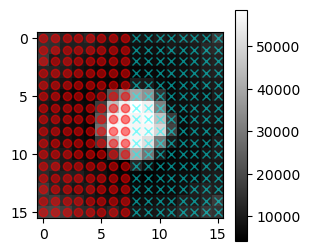

In [5]:
brightnesses = np.zeros((16, 16))
plt.figure(figsize=(3, 3))

for i in range(16):
    for j in range(16):
        brightnesses[i, j] = np.mean(phantom[i][j])
#         if j != 0:  # crop left-most column to align
        if j <= 7.5:
            plt.plot(j, i, 'o', color='red', alpha=0.5)
        if j >= 7.5:
            plt.plot(j, i, 'x', color='cyan', alpha=0.5)

plt.imshow(brightnesses, cmap='gray')
plt.colorbar()
plt.show()

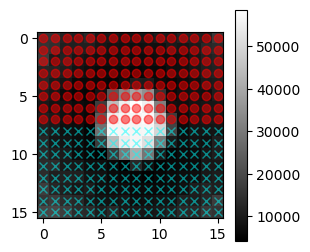

In [6]:
brightnesses = np.zeros((16, 16))
plt.figure(figsize=(3, 3))

for i in range(16):
    for j in range(16):
        brightnesses[i, j] = np.mean(phantom[i][j])
#         if j != 0:  # crop left-most column to align
        if i <= 7.5:
            plt.plot(j, i, 'o', color='red', alpha=0.5)
        if i >= 7.5:
            plt.plot(j, i, 'x', color='cyan', alpha=0.5)

plt.imshow(brightnesses, cmap='gray')
plt.colorbar()
plt.show()

## Phase gradient

Use the indexing above to generate the illumination images, then pass into `plot_phase_gradient` to perform the necessary subtraction and integration. Optionally plot a row for debugging. 

In [7]:
def plot_phase_gradient(img1, img2, sum_ax=1, labels=["img1", "img2"], plot_row=None):
    
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    mpbl = axs[0].imshow(img1, cmap='gray')
    plt.colorbar(mpbl)
    axs[0].set_title(f'{labels[0]} illumination')
    mpbl = axs[1].imshow(img2, cmap='gray')
    plt.colorbar(mpbl)
    axs[1].set_title(f'{labels[1]} illumination')
    phsgrd = (img1-img2)/(img1+img2)
    mpbl = axs[2].imshow(phsgrd)
    plt.colorbar(mpbl)
    axs[2].set_title(f'{labels[0]}-{labels[1]} DPC')
    mpbl = axs[3].imshow(np.cumsum(phsgrd, axis=sum_ax))
    plt.colorbar(mpbl)
    axs[3].set_title('1D integration')
    
    if plot_row is not None:
        for ax in axs:
            ax.axhline(y=plot_row)
    
    plt.show()
    
    if plot_row is not None:
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))

        axs[0].plot(img1[plot_row, :])
        axs[0].set_title(f'{labels[0]} illumination')
        axs[1].plot(img2[plot_row, :])
        axs[1].set_title(f'{labels[1]} illumination')
        axs[2].plot(phsgrd[plot_row, :])
        axs[2].set_title(f'{labels[0]}-{labels[1]} DPC')
        axs[3].plot(np.cumsum(phsgrd, axis=sum_ax)[plot_row, :])
        axs[3].set_title('integral(DPC)')
        plt.show()
    
    return phsgrd

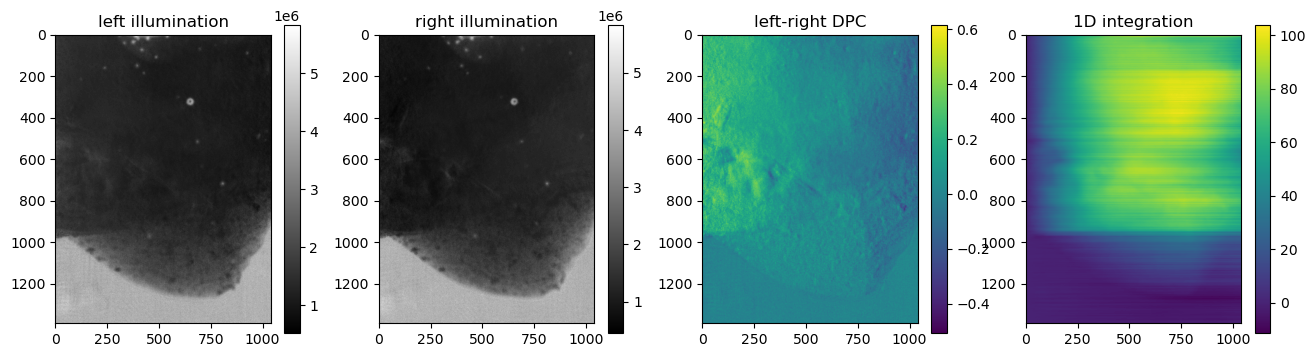

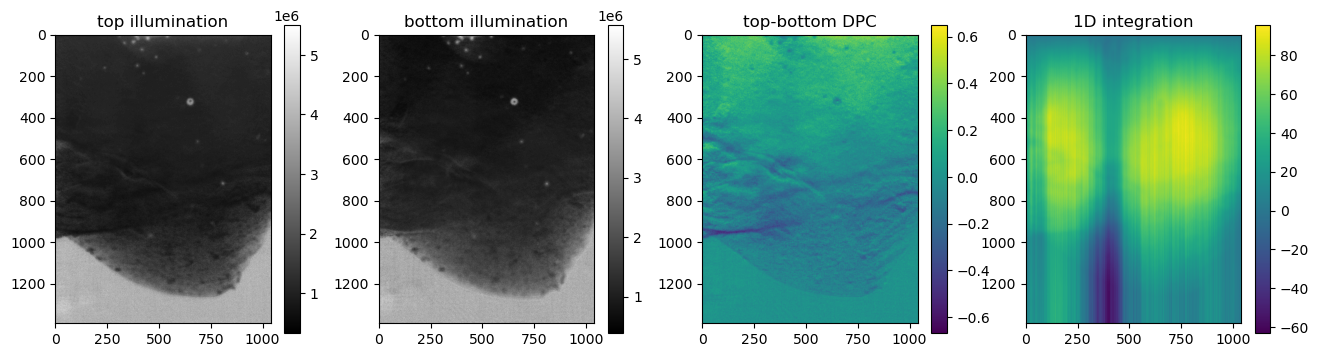

In [8]:
left = np.zeros((1392, 1040))
right = np.zeros((1392, 1040))
top = np.zeros((1392, 1040))
bottom = np.zeros((1392, 1040))

for i in range(16):
    for j in range(16):
        if j != 0:
            if j <= 8:
                left += phantom[i][j]
            if j >= 8:
                right += phantom[i][j]
            if i <= 7.5:
                top += phantom[i][j]
            if i >= 7.5:
                bottom += phantom[i][j]
                
plot_row = 1200

phi_x = plot_phase_gradient(left, right, sum_ax=1, labels=["left", "right"])
phi_y = plot_phase_gradient(top, bottom, sum_ax=0, labels=["top", "bottom"])

### Attempting 2D Fourier integral method

Simple 1D integration doesn't work, probably because:
- our sample is thicc (so phase probably wraps many times over)
- our sample leaves the field of view (so we have unknown boundary conditions)
- we have low counting statistics (high noise)

So instead we should try the 2D Fourier method:

$$ \Phi (x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[\Phi_x + i \Phi_y](k, l)}{2\pi i (k + il)}](x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[g](k, l)}{2\pi i (k + il)}](x, y) $$

Source: [A two-directional approach for grating based differential phase contrast imaging using hard X-rays](https://www.researchgate.net/publication/26297519_A_two-directional_approach_for_grating_based_differential_phase_contrast_imaging_using_hard_X-rays)

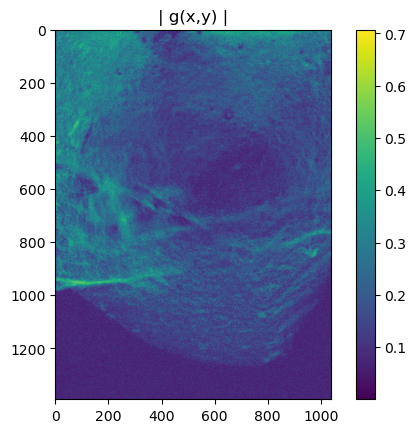

In [9]:
g = phi_x + (1j * phi_y)
plt.imshow(np.abs(g))
plt.title('| g(x,y) |')
plt.colorbar()
plt.show()

In [10]:
def fourier(image):
    ft = np.fft.ifftshift(image)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    freq_x = np.fft.fftfreq(ft.shape[0])
    freq_y = np.fft.fftfreq(ft.shape[1])
    freq_x = np.fft.fftshift(freq_x)
    freq_y = np.fft.fftshift(freq_y)

    plt.imshow(np.abs(ft), extent=(freq_x.min(),freq_x.max(),freq_y.min(),freq_y.max()))
    plt.colorbar()
    plt.xlabel('k')
    plt.ylabel('l')
    plt.show()
               
    return ft, (freq_x, freq_y)

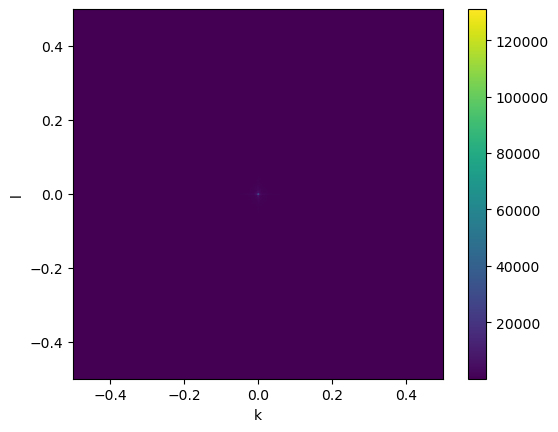

In [11]:
ft_g, (freq_x, freq_y) = fourier(g)
# np.max(np.abs(ft_g))
# there's something there, even if we can't see it...

In [12]:
# denominator of the fraction
freq_xx, freq_yy = np.meshgrid(freq_x, freq_y, indexing='ij')
denom = ((2. * np.pi * 1.0j) * (freq_xx + (1.0j * freq_yy))) + 5e-16

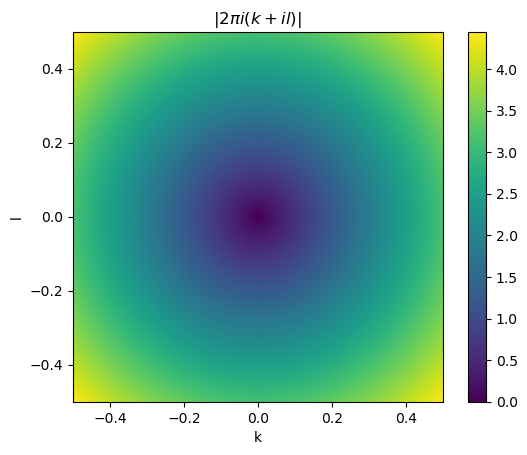

In [13]:
plt.imshow(np.abs(denom), extent=(freq_x.min(),freq_x.max(),freq_y.min(),freq_y.max()))
plt.xlabel('k')
plt.ylabel('l')
plt.title(r'$|2 \pi i (k+il)|$')
plt.colorbar()
plt.show()

In [14]:
# plt.imshow(np.abs(ft_g / denom), extent=(freq_x.min(),freq_x.max(),freq_y.min(),freq_y.max()))
# plt.colorbar()
# plt.title(r'$|\frac{\mathcal{F}[\Phi_x + i \Phi_y](k, l)}{2\pi i (k + il)}|$')
# plt.show()

In [15]:
def inv_fourier(ft):
    ift = np.fft.ifftshift(ft)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)

    return ift

In [16]:
# plt.imshow(np.abs(inv_fourier(ft_g)))
# plt.colorbar()
# plt.title('inv. FT. without dividing')
# plt.show()
# # THIS IS NOT OUR PHASE CONTRAST IMAGE
# # we haven't divided by the 2*pi*i*(k+il), so we haven't actually integrated!
# # just want to check that the FT and IFT work
# # original added image recovered

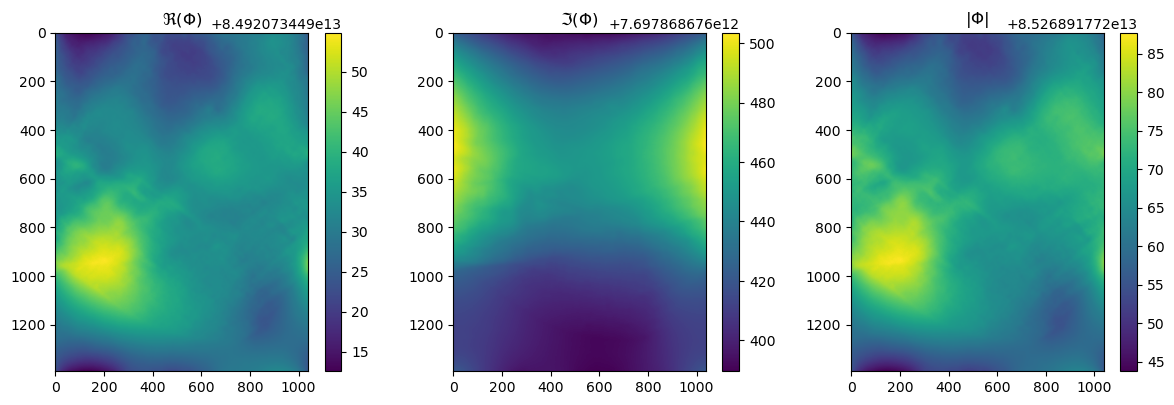

In [17]:
phi = inv_fourier(ft_g / denom)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
mp = axs[0].imshow(np.real(phi))
plt.colorbar(mp)
axs[0].set_title(r'$\Re{(\Phi)}$')
mp = axs[1].imshow(np.imag(phi))
plt.colorbar(mp)
axs[1].set_title(r'$\Im{(\Phi)}$')
mp = axs[2].imshow(np.abs(phi))
plt.colorbar(mp)
axs[2].set_title(r'$|\Phi|}$')
plt.tight_layout()
plt.show()

## Digital refocusing

$I^{\Delta Z} = \Sigma I_i(x + \Delta z \tan{\theta_x}, y + \Delta z \tan{\theta_y})$, where $\tan{\theta_x} = \frac{\Delta x}{L} = \frac{(16-i) \times 4 mm}{L}$ and $\tan{\theta_y} = \frac{(j-16) \times 4 mm}{L}$, if we define x upwards and y to the right of the central LED (since (0,0) is top-left). 
 
NOTE: effect of water on k-vector?

In [18]:
def shift_image(image, x_shift_mm, y_shift_mm):
    """
    Return translated image, given x and y shifts in mm,
    assuming a pixel size of 6.45um
    """
    x_shift_px = x_shift_mm / 6.45e-3
    y_shift_px = y_shift_mm / 6.45e-3
    
    M = np.float32([
        [1, 0, x_shift_px],
        [0, 1, y_shift_px]
    ])
    
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


def required_shifts(i, j, delta_z, L=355):
    """
    Calculated required shifts in mm given LED coordinates
    and required refocus distance delta_z, assuming a 32x32
    LED array with pitch 4mm, with LED (16, 16) centred on 
    the optical axis, and with (0, 0) at the top left.
    """
    delta_x = (16-i) * 4
    tan_theta_x = delta_x / L
    x_shift_mm = delta_z * tan_theta_x
    
    delta_y = (j-16) * 4
    tan_theta_y = delta_y / L
    y_shift_mm = delta_z * tan_theta_y
    
    
    return x_shift_mm, y_shift_mm


def refocus_img(imgs, delta_z):
    refocused = np.zeros((1392, 1040))
    for i in range(16):
        for j in range(16):
            if j != 0:
                x_shift_mm, y_shift_mm = required_shifts(i, j, delta_z)
                refocused += shift_image(imgs[i][j], x_shift_mm, y_shift_mm)
    return refocused

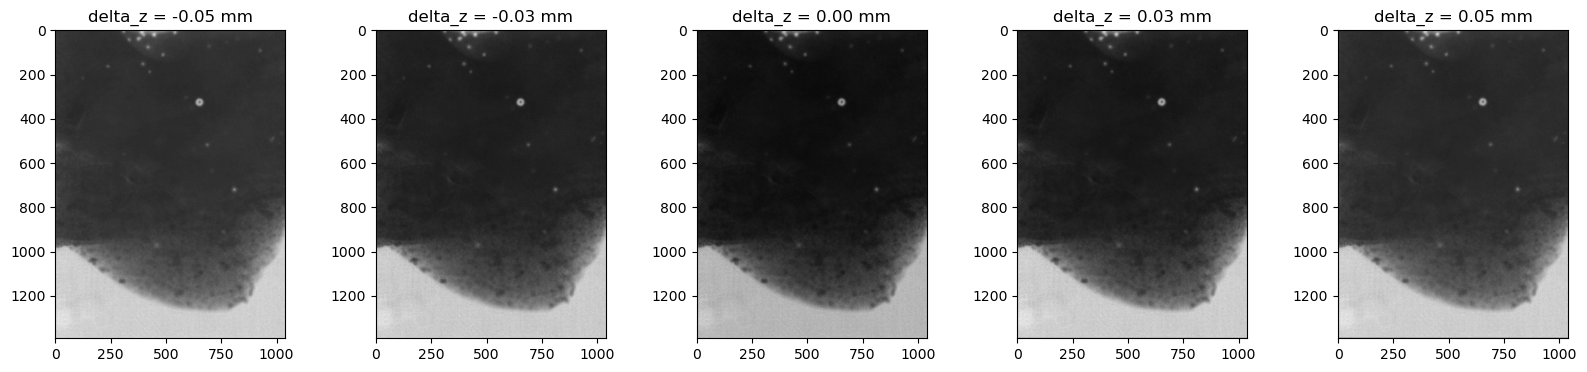

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, shift in zip(range(5), np.linspace(-0.05, 0.05, 5)):
    axs[i].imshow(refocus_img(phantom, shift), cmap='gray')
    axs[i].set_title(f'delta_z = {shift:.2f} mm')

## Checking the projection images

In [20]:
img_dir = r'D:\MSci_Project\1_Data\2023-03-15'
background = io.imread(img_dir + r'\2023-03-15 phase phantom 400proj background.tif')
phantom = io.imread(img_dir + r'\2023-03-15 phase phantom 400proj first4.tif')

phantom -= background

phantom = np.moveaxis(phantom, -1,0)
phantom.shape

(4, 1392, 1040)

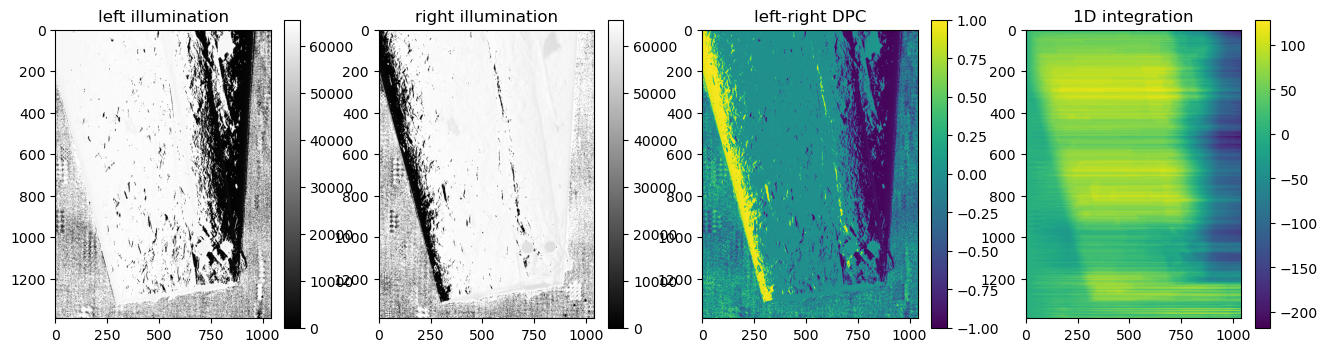

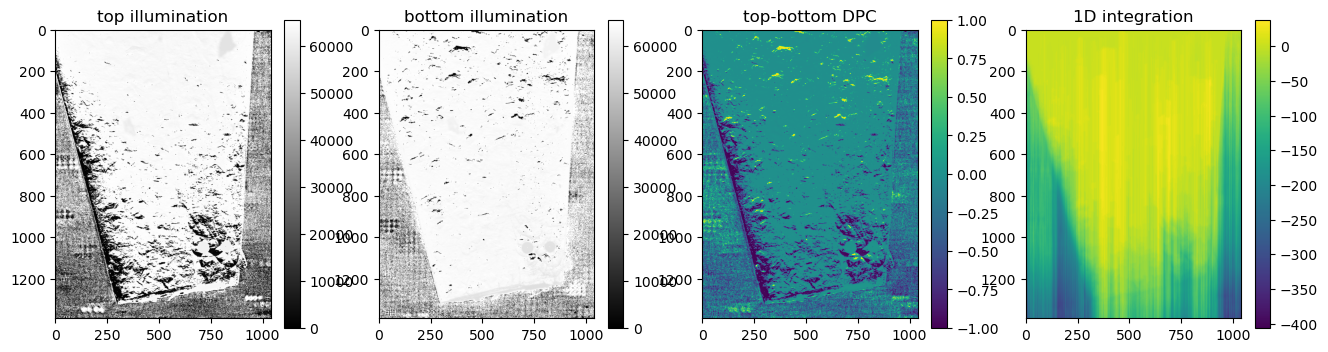

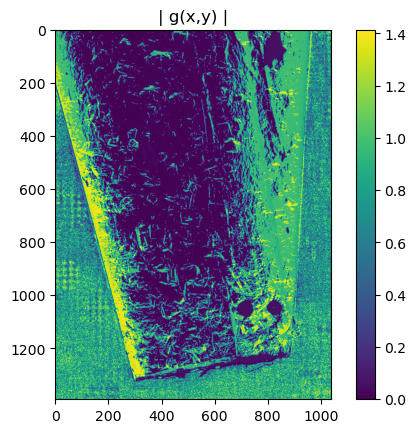

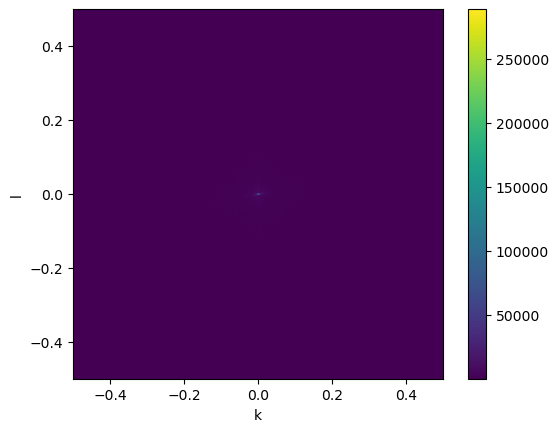

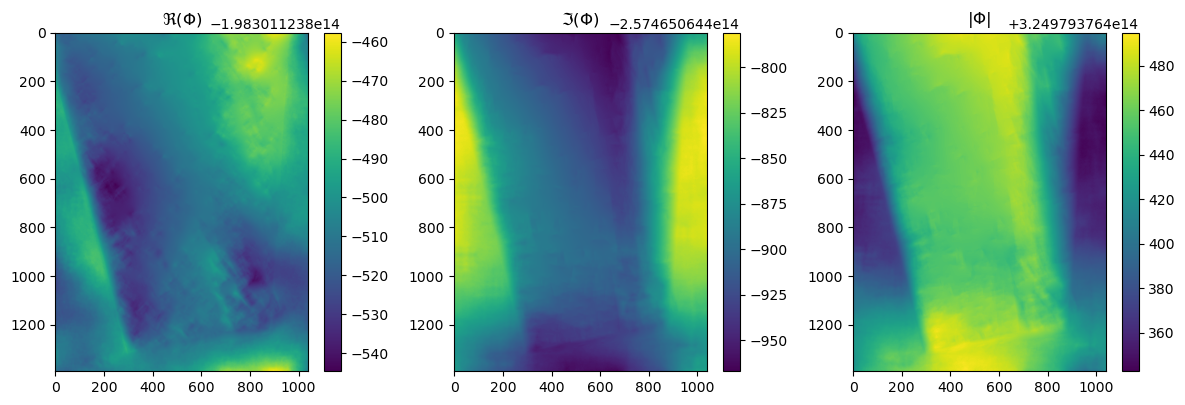

In [21]:
left = phantom[0] + 5e-16
right = phantom[1] + 5e-16
top = phantom[2] + 5e-16
bottom = phantom[3] + 5e-16

phi_x = plot_phase_gradient(left, right, sum_ax=1, labels=["left", "right"])
phi_y = plot_phase_gradient(top, bottom, sum_ax=0, labels=["top", "bottom"])

g = phi_x + (1j * phi_y)
plt.imshow(np.abs(g))
plt.title('| g(x,y) |')
plt.colorbar()
plt.show()

ft_g, (freq_x, freq_y) = fourier(g)

# denominator of the fraction
freq_xx, freq_yy = np.meshgrid(freq_x, freq_y, indexing='ij')
denom = ((2. * np.pi * 1.0j) * (freq_xx + (1.0j * freq_yy))) + 5e-16

phi = inv_fourier(ft_g / denom)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
mp = axs[0].imshow(np.real(phi))
plt.colorbar(mp)
axs[0].set_title(r'$\Re{(\Phi)}$')
mp = axs[1].imshow(np.imag(phi))
plt.colorbar(mp)
axs[1].set_title(r'$\Im{(\Phi)}$')
mp = axs[2].imshow(np.abs(phi))
plt.colorbar(mp)
axs[2].set_title(r'$|\Phi|}$')
plt.tight_layout()
plt.show()